In [1]:
from skimage import io, color
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mse(i1, i2):
    return ((i1 - i2)**2).sum() / i1.shape[0] / i1.shape[1]
        
def corr(i1, i2):
    return - (i1 * i2).sum() / np.sqrt((i1**2).sum() * (i2**2).sum())

def process_origin(origin):
    height = origin.shape[0]
    channel1, channel2, channel3 = origin[:height/3, :], origin[height/3:height/3*2, :], origin[height/3*2: height/3*3,:]
    border_w = channel1.shape[1]/15
    border_h = channel1.shape[0]/15
    channel1 = channel1[border_h:-border_h, border_w:-border_w]
    channel2 = channel2[border_h:-border_h, border_w:-border_w]
    channel3 = channel3[border_h:-border_h, border_w:-border_w]
    channels = np.array([channel1, channel2, channel3])
    return channels

def get_cropped_images(shifts, i1, i2):
    x_shift, y_shift = shifts
    if x_shift > 0:
        i1 = i1[x_shift:, :]
    else:
        i2 = i2[-x_shift:, :]
    if y_shift > 0:
        i1 = i1[:, y_shift:]
    else:
        i2 = i2[:, -y_shift:]
    if i1.shape[0] > i2.shape[0]:
        i1 = i1[:i2.shape[0], :]
    else:
        i2 = i2[:i1.shape[0], :]
    if i1.shape[1] > i2.shape[1]:
        i1 = i1[:, :i2.shape[1]]
    else:
        i2 = i2[:, :i1.shape[1]]
        
    return i1, i2

def find_optimal_shift(i1, i2, metric, ranges):
    optimal_shifts = np.zeros(2)
    optimal_value = 1e6
    for shift_x in xrange(ranges[0], ranges[1]):
        for shift_y in xrange(ranges[2], ranges[3]):
            shifts = np.array([shift_x, shift_y])
            i1_cropped, i2_cropped = get_cropped_images(shifts.astype(int), i1, i2)
            value = metric(i1_cropped, i2_cropped)
            if value < optimal_value:
                optimal_value = value
                optimal_shifts = shifts
    return optimal_shifts

def pyramid(img_big, metric):
    pyramid = [img_big]
    while img_big[0].shape[0] >= 500:
        img_big = np.array([resize(img_big[i], (img_big[i].shape[0] / 2, img_big[i].shape[1] / 2)) for i in range(3)])
        pyramid.append(img_big)
    pyramid = pyramid[::-1]
    
    maxx12 = maxy12 = maxx13 = maxy13 = 20
    minx12 = miny12 = minx13 = miny13 = -20
    for img in pyramid:
        shifts12 = find_optimal_shift(img[0], img[1], metric, (minx12, maxx12, miny12, maxy12))
        shifted1, shifted2 = get_cropped_images(shifts12, img[0], img[1])
        shifts13 = find_optimal_shift(shifted1, img[2], metric, (minx13, maxx13, miny13, maxy13))
        shifted1, shifted3 = get_cropped_images(shifts13, shifted1, img[2])
        minx12, maxx12, miny12, maxy12 = 2*shifts12[0]-1, 2*shifts12[0]+1, 2*shifts12[1]-1, 2*shifts12[1]+1
        minx13, maxx13, miny13, maxy13 = 2*shifts13[0]-1, 2*shifts13[0]+1, 2*shifts13[1]-1, 2*shifts13[1]+1
    if shifts13[0] > 0:
        shifted2 = shifted2[shifts13[0]:, :]
    elif shifts13[0] < 0:
        shifted2 = shifted2[-shifts13[0]:, :]
    if shifts13[1] > 0:
        shifted2 = shifted2[:, shifts13[1]:]
    elif shifts13[1] < 0:
        shifted2 = shifted2[:, -shifts13[1]:]
    
    return np.array([shifted3, shifted2, shifted1]).transpose(1,2,0)
    
# Пирамида работает на маленьких изображениях как простой align
def align(img, metric=mse):
    return pyramid(process_origin(img), metric)

# Сравнение метрик

CPU times: user 2.06 s, sys: 740 ms, total: 2.8 s
Wall time: 2.02 s


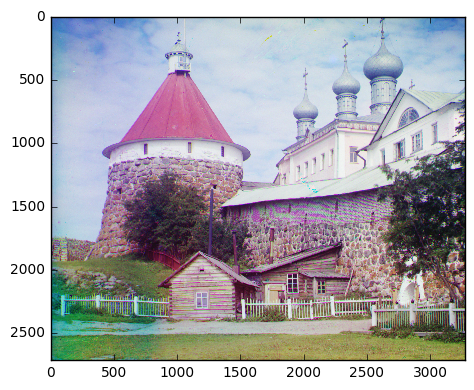

In [4]:
img = io.imread('./big/00348a.png')
%time io.imshow(align(img, mse))

/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ilya/.virtualenvs/images/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 3.02 s, sys: 744 ms, total: 3.76 s
Wall time: 3 s


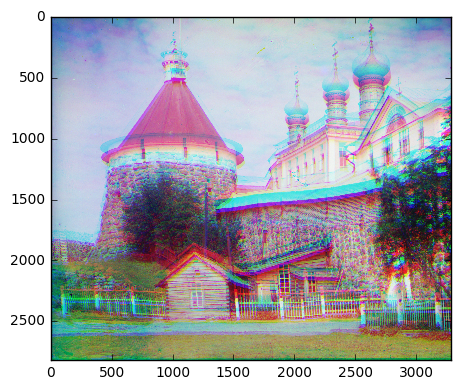

In [5]:
img = io.imread('./big/00348a.png')
%time io.imshow(align(img, corr))

# Все изображения

CPU times: user 428 ms, sys: 20 ms, total: 448 ms
Wall time: 422 ms


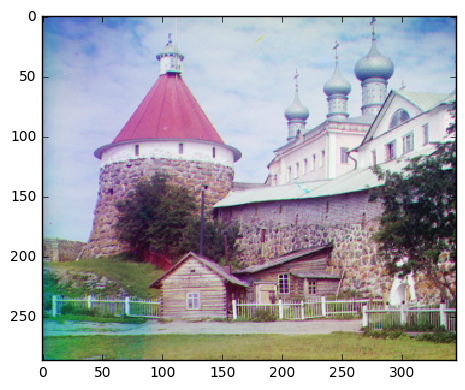

In [6]:
img = io.imread('./small/00348a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.24 s, sys: 740 ms, total: 2.98 s
Wall time: 2.19 s


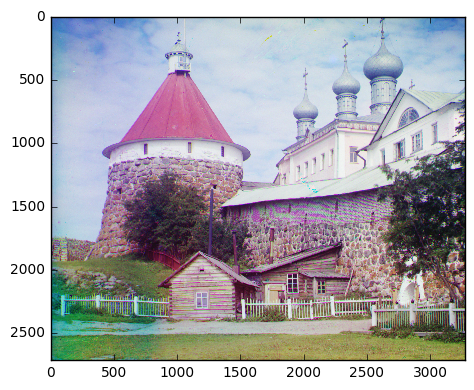

In [7]:
img = io.imread('./big/00348a.png')
%time io.imshow(align(img, mse))

CPU times: user 568 ms, sys: 20 ms, total: 588 ms
Wall time: 563 ms


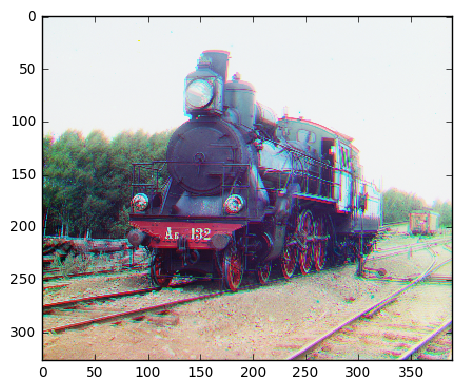

In [8]:
img = io.imread('./small/00458a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.11 s, sys: 744 ms, total: 2.85 s
Wall time: 2.1 s


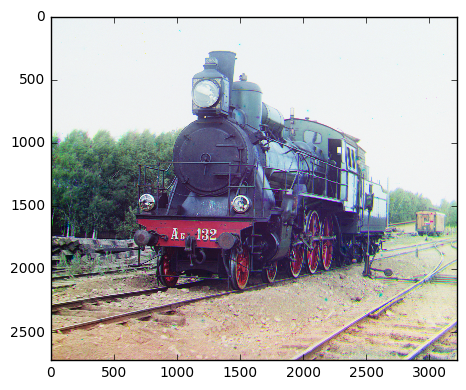

In [9]:
img = io.imread('./big/00458a.png')
%time io.imshow(align(img, mse))

CPU times: user 508 ms, sys: 36 ms, total: 544 ms
Wall time: 516 ms


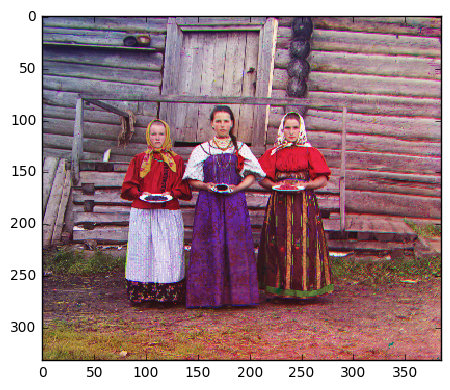

In [10]:
img = io.imread('./small/01043a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.4 s, sys: 692 ms, total: 3.09 s
Wall time: 2.36 s


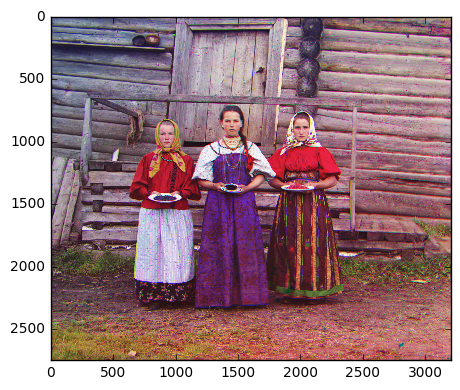

In [11]:
img = io.imread('./big/01043a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.03 s, sys: 760 ms, total: 2.79 s
Wall time: 2.03 s


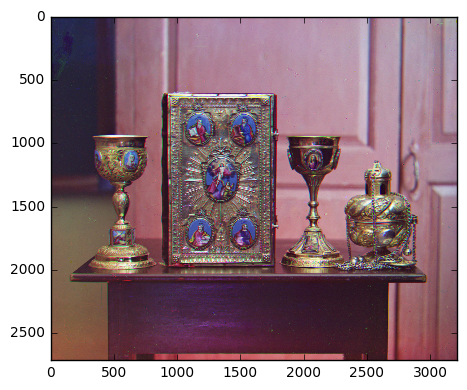

In [12]:
img = io.imread('./big/01047a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.19 s, sys: 716 ms, total: 2.91 s
Wall time: 2.15 s


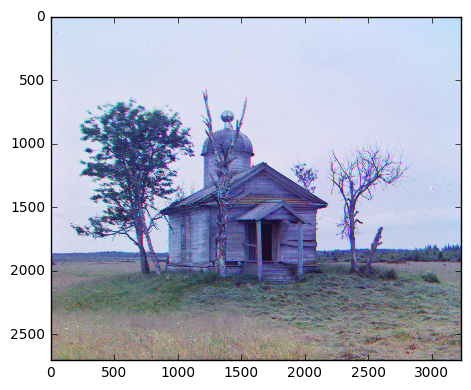

In [13]:
img = io.imread('./big/01069a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.2 s, sys: 668 ms, total: 2.86 s
Wall time: 2.1 s


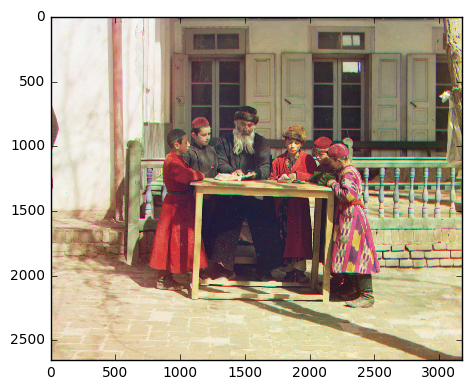

In [14]:
img = io.imread('./big/01861a.png')
%time io.imshow(align(img, mse))

CPU times: user 2.06 s, sys: 752 ms, total: 2.81 s
Wall time: 2.05 s


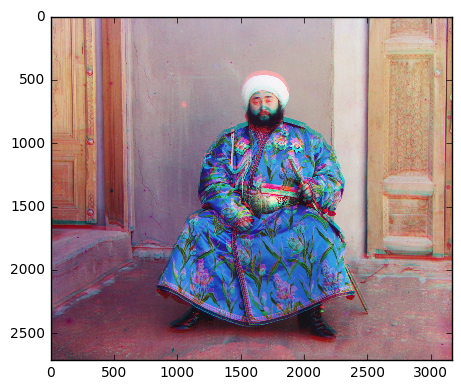

In [15]:
img = io.imread('./big/01886a.png')
%time io.imshow(align(img, mse))